# NLP to Distinguish Fake Phishing and Spam Job Emails

Problem: The problem that will be tackled in this project is identifying fake or real job opportunity emails. There are many spam emails or phishing emails targetting job seekers and it would be beneficial to distinguish between real or fake job opportunities in emails. This task will be done using natural language processing models such as GRU (gated recurrent unit) for its sequential data processing capabilities and conv1d (1D Convolutional Neural Network) for its short term pattern recognition abilities. 

Data: The dataset consists of approximately 1,000 labeled emails, each marked as either "real" or "fake". It has a raw column, text, and label columns. The raw column is how the data is unorganized, the text contains the body of the email, and the label shows 0 as a real job email and 1 as a fake job email. The data is in a tabular format and was generated through self-prompting using ChatGPT to simulate realistic examples of both legitimate and fraudulent job emails.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import register_keras_serializable

## EDA

EDA procedure:
- Import data and look at dimension and structure
- Bar chart to see distribution of labels (0 real or 1 fake). This is to see if the data is skewed or biased toward being real or fake.
- Histogram to see distribution of email lengths. This is also to see if the data is skewed or baised toward being shorter or longer.
- Boxplot to see length of emails with respect to labels. This is to see if the data is biased towards being shorter or longer for real or fake emails.
- Bar chart to see the top 20 most common words in fake emails. Just a visualization to see if there are any patterns in language or words used in fake emails.
- Outliers will be left in as email length can vary in real job opportunity emails as well as fake job emails.
- Before analysis a specific factor I think will be important are length of emails. I am worried that it might impact how well the model is trained.

In [2]:
# import data

data = pd.read_csv('data/email_data.csv')
print(data.head)

<bound method NDFrame.head of                                                    raw  \
0    Subject: Job Offer for Marketing Manager Posit...   
1    Subject: Congratulations! You've Been Selected...   
2    Subject: Immediate Hiring Opportunity! (No Exp...   
3    Subject: Software Developer Position at Innova...   
4    Subject: Urgent Work-From-Home Opportunity! De...   
..                                                 ...   
983  Subject: Interview Invitation - Data Entry Cle...   
984  Subject: Work Online - Start Immediately Dear ...   
985  Subject: Interview Scheduling - Quality Assura...   
986  Subject: Flexible Remote Work Available Dear J...   
987  Subject: Interview Invitation - Technical Supp...   

                                                  text  label  
0    Subject: Job Offer for Marketing Manager Posit...      0  
1    Subject: Congratulations! You've Been Selected...      0  
2    Subject: Immediate Hiring Opportunity! (No Exp...      1  
3    Subject: Sof

The data has 988 rows and 3 columns each: raw (raw text), text (email body), and label.

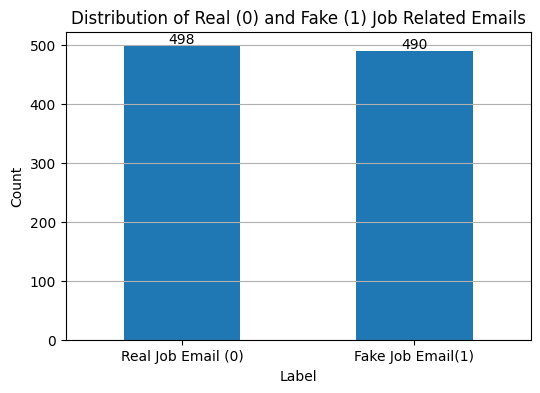

In [3]:
# histogram to see distribution of labels
plt.figure(figsize=(6,4))
label_count = data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Real (0) and Fake (1) Job Related Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1], ['Real Job Email (0)', 'Fake Job Email(1)'], rotation=0)
plt.grid(axis='y')

# add values on top
for p in label_count.patches:
    label_count.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()    

The amount of real vs fake job emails are about even so there should not be a lot of bias in the data.

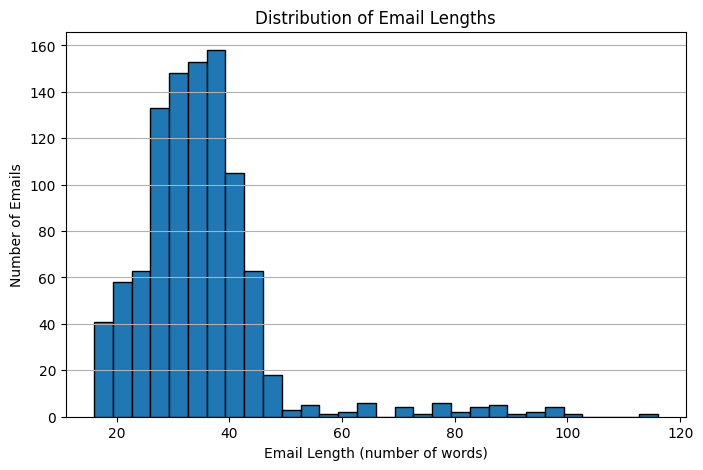

In [4]:
# histogram of email lengths

word_count_list = []
for email in data['text']:
    word_count = email.split() # splits email into list of words
    word_count_list.append(len(word_count))
    
plt.figure(figsize=(8,5))
plt.hist(word_count_list, bins=30, edgecolor='black')
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length (number of words)')
plt.ylabel('Number of Emails')
plt.grid(axis='y')
plt.show()

Most emails tend to be between the 20 to 40 word range. There are some outliers that are longer, some around 60, some around 100, the highest outlier being almost 120 words long. Since the range seems skewed between the 20-40 range, some normalization methods might need to be employed so that the length does not influence the decision of the GRU model.

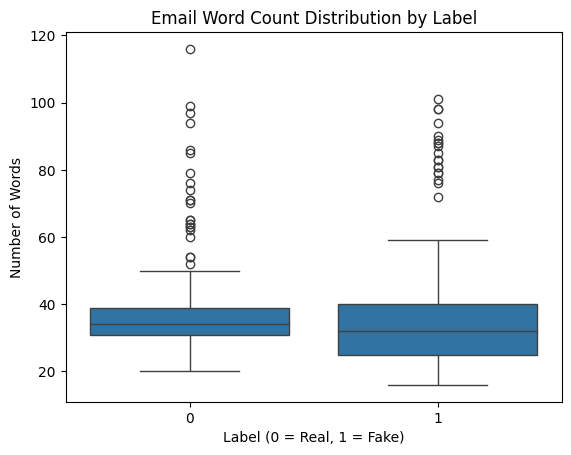

In [5]:
# boxplot to see length distribution by label
sns.boxplot(x=data['label'], y=data['text'].apply(lambda x: len(x.split())))
plt.title("Email Word Count Distribution by Label")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Number of Words")

plt.show()

There are a lot of outliers for both real and fake emails. The first and third quartile gap (edge of blue box) for word length is larger for fake emails than real emails. This gap or spread represents where 50% of the data is ranging in terms of word length. The median line is within the quartile gap is about the same word length for both real and fake emails. The gap for the whiskers representing 1.5 times the iqr of the quartile lines (edge of blue boxes * 1.5). This gap is about even for real emails and has a bigger upper whisker than lower for fake emails. Takeaways are fake emails are not as consistent, some are short and some are long. Real emails are more professional and hover around a certain range more frequently. Since word length median seems to be about the same for real and fake, it might be hard to distinguish solely off word length. Personally, I am thinking of keeping the outliers in the data because in the real world emails tend to range in length and I keeping it in would make it more realistic.

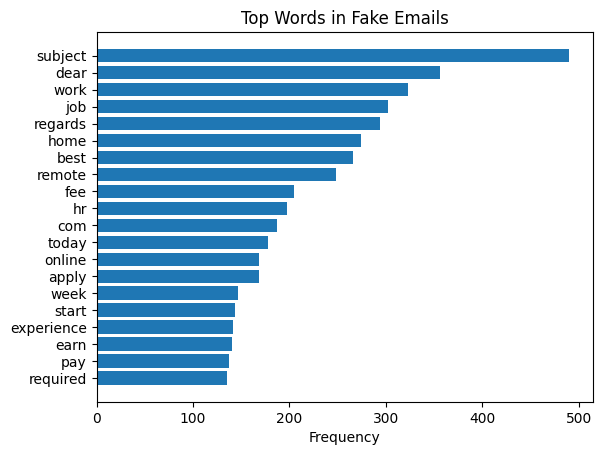

In [6]:
# most common words
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data[data['label'] == 1]['text'])  # Only fake for example
word_counts = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Plot top 20
top_idx = word_counts.argsort()[-20:][::-1]
plt.barh([words[i] for i in top_idx], [word_counts[i] for i in top_idx])
plt.title("Top Words in Fake Emails")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.show()

Subject appears the most but this is due to how the data formatted the subject header, might need to remove that during data cleaning. The words most commonly used seem normal to real job opportunity emails so training using the entire context rather than just individual words might be the best course of action for this classification task.

## Cleaning Data

- Check if all emails have a label
- Check for duplicate text
- Lowercase all text to prevent repeat words while training
- Remove unwanted words
- Remove special characters but leave @ and $ as they are relevant in some job emails
- Remove all white spaces in text

In [7]:
# check if all emails have a label
missing_labels = data['label'].isnull().sum()
print(f"Number of missing labels: {missing_labels}")

# check for duplicate text
duplicate_texts = data['text'].duplicated().sum()
print(f"Number of duplicate emails: {duplicate_texts}")

Number of missing labels: 0
Number of duplicate emails: 0


In [8]:
# lowercase all text
data['text'] = data['text'].str.lower()

In [9]:
# remove unwanted words
data['text'] = data['text'].str.replace(r'\bSubject:\b', '', case=False, regex=True)

# remove special characters, only keeping @ and $. These characters are relevant in some job emails so might be worth keeping.
data['text'] = data['text'].str.replace(r'[^\w\s@$]', '', regex=True)

# remove all white space
data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

data.text.head

<bound method NDFrame.head of 0      subject job offer for marketing manager positi...
1      subject congratulations youve been selected fo...
2      subject immediate hiring opportunity no experi...
3      subject software developer position at innovat...
4      subject urgent workfromhome opportunity dear a...
                             ...                        
983    subject interview invitation data entry clerk ...
984    subject work online start immediately dear ale...
985    subject interview scheduling quality assurance...
986    subject flexible remote work available dear ju...
987    subject interview invitation technical support...
Name: text, Length: 988, dtype: object>

In [10]:
# split data into training, validation, and test
train_and_val, test = train_test_split(data, test_size=0.2, random_state=42) # training + validation = 80% and testing = 20%
train, val = train_test_split(train_and_val, test_size=0.2, random_state=42) # training = 80% and validation = 20%
print('training shape: ', train.shape)
print('validation shape: ', val.shape)
print('testing shape: ', test.shape)

training shape:  (632, 3)
validation shape:  (158, 3)
testing shape:  (198, 3)


In [11]:
# tokenize the text 
vocab_size = 10000 # max number of words, limits vocabulary size in tokenization
max_length = 60 # max email length in tokens, pads sequences to ensure same length during training
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # replaces unknown words with special '<OOV>' placeholder
tokenizer.fit_on_texts(train['text'])

# pad training text
train_seq = tokenizer.texts_to_sequences(train['text'])
train_seq_pad = pad_sequences(train_seq, maxlen=max_length, padding='post')

# pad validation text
val_seq = tokenizer.texts_to_sequences(val['text'])
val_seq_pad = pad_sequences(val_seq, maxlen=max_length, padding='post')

# pad test text for later
test_seq = tokenizer.texts_to_sequences(test['text'])
test_seq_pad = pad_sequences(test_seq, maxlen=max_length, padding='post')

print(train_seq_pad)

[[  3  12   5 ...   0   0   0]
 [  3  52   4 ...   0   0   0]
 [  3 155  16 ...   0   0   0]
 ...
 [  3  47 234 ...   0   0   0]
 [  3  12 149 ...   0   0   0]
 [  3  48 125 ...   0   0   0]]


Need to tokenize the text so each word is represented by a unique integer that the model can process during its training. Padding is necessary to ensure all input text has the same length, this is required for batching and feeding data into the model.

## Analysis

My plan of analysis is to use a GRU (gated recurrent unit) model for binary classification of my email data. Classifying whether or not the email contains real job related opportunities or is a scam or fake. This model is good for sequential data which is fitting for identifying fake job emails because many words are generally used in these types of emails as can be seen on the top 20 most common words bar chart above, the context of the entire email will be required to make a decision rather than individual words. Following that I plan on creating a conv1 model for comparison. Conv1 models are also somewhat relevant for this task because it is good at identifying short patterns across phrases and word combinations. Since the batch of email data I currently collected are rather on the shorter side, 50% being between 20 to 40 words in length. Finally, I will utilize the keras tuner library to do hyperparameter tuning for both models.

Model Architecture: Layers in the GRU model include: embedding, GRU, dropout, and dense. The embedding layer is meant for representing text as word vectors for training. The GRU layer contains hidden layers that will do computation and learning for our task, maintaining context. The batch normalization layer is meant as an additional safeguard against overfitting. The dropout layer is used to prevent overfitting. The dense layer is the output layer, which outputs a value between 0 and 1.

Layers in the Conv1d model include embedding, conv1d, GlobalMaxPooling1D, droput, and dense. The conv1d layer does the computation and learning and the globalmaxpooling1d layer maintains previous short patterns through pooling techniques.

In [12]:
# build the GRU model

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    GRU(64, return_sequences=False), # 64 hidden
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # output layer should be between 0 and 1 so use sigmoid activation function
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_seq_pad, train['label'], validation_data=(val_seq_pad, val['label']), epochs=10, batch_size=32, verbose=1)

Epoch 1/10


C:\Users\Kyle\Desktop\ml week 6\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5260 - loss: 0.6871 - val_accuracy: 0.5253 - val_loss: 0.6929
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4714 - loss: 0.6902 - val_accuracy: 0.4873 - val_loss: 0.6936
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5152 - loss: 0.6849 - val_accuracy: 0.4873 - val_loss: 0.6937
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5174 - loss: 0.6676 - val_accuracy: 0.4873 - val_loss: 0.6929
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5230 - loss: 0.6760 - val_accuracy: 0.5253 - val_loss: 0.6917
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5308 - loss: 0.6680 - val_accuracy: 0.5127 - val_loss: 0.7005
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9451 - loss: 0.1870 - val_accuracy: 0.9620 - val_loss: 0.2690
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9927 - loss: 0.0281 - val_accuracy: 0.9937 - val_loss: 0.

In [13]:
val_loss, val_acc = model.evaluate(val_seq_pad, val['label'])
print('validation accuracy for GRU model: ' , val_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0411 
validation accuracy for GRU model:  0.9936708807945251


### Hyperparameter Tuning

- vocab size [2500, 5000, 10000], vocab size might add unneccessary noise causing overfitting or miss important tokens from being too small. Should try from 10,000 and go down since the emails sort of skew toward being shorter.
- max length [30, 60, 80], should try different ball park of where most email lengths are based on histogram from above from eda. 
- embedding [32, 64, 168], impacts word vector representation while training, may capture more detail if big or overfit if dataset is small.
- gru/conv1d [32, 64, 128], amount of units in the model, different rates impact how well the hidden layers perform
- dropout [0.3, 0.5, 0.7], influences overfitting control

In [14]:
def build_gru_model(hp):
    vocab_size = hp.Choice('max_vocab', [2500, 5000, 10000])  # max number of words, limits vocabulary size in tokenization
    max_length = hp.Choice('max_words', [30, 60, 80]) # max email length in tokens, pads sequences to ensure same length during training
    model = Sequential([
    Embedding(input_dim=vocab_size, output_dim= hp.Choice('embedding_output_dim', [32, 64, 168]), input_length=max_length),
    GRU(hp.Choice('gru_units', [32, 64, 128]), return_sequences=False),
    BatchNormalization(),
    Dropout(hp.Choice('dropout', [0.3, 0.5, 0.7])),
    Dense(1, activation='sigmoid') # output layer should be between 0 and 1 so use sigmoid activation function
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tunerGRU = kt.RandomSearch(
    build_gru_model,
    objective=kt.Objective('val_accuracy', direction='max'),  # tell Keras Tuner to maximize validation accuracy score
    max_trials=10, # 10 combinations
    executions_per_trial=1, # how many times to run a hyperparameter combination
    directory='tuner_dir', # directory to save tuner log
    project_name='emails_GRU' 
)
tunerGRU.search(train_seq_pad, train['label'], epochs=10, validation_data=(val_seq_pad, val['label']), verbose=1)

Reloading Tuner from tuner_dir\emails_GRU\tuner0.json


## Results

In [15]:
# get best performing tuned GRU model
best_GRU = tunerGRU.get_best_models(num_models=1)[0]
best_GRU_hypparam = tunerGRU.get_best_hyperparameters(num_trials=1)[0]
print(best_GRU_hypparam.values)


{'max_vocab': 10000, 'max_words': 30, 'embedding_output_dim': 64, 'gru_units': 128, 'dropout': 0.7}


C:\Users\Kyle\Desktop\ml week 6\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
# table of each trial and validation accuracy score at each trial along with hyperparameters for the gru model
trial_data = []

for trial in tunerGRU.oracle.trials.values():
    trial_data.append({
        'Trial #': trial.trial_id,
        **trial.hyperparameters.values,
        'Val Accuracy': trial.score
    })

gru_trial_df = pd.DataFrame(trial_data)
gru_trial_df = gru_trial_df.sort_values(by='Val Accuracy', ascending = False)
display(gru_trial_df)

,Trial #,max_vocab,max_words,embedding_output_dim,gru_units,dropout,Val Accuracy
2,04,10000,30,64,128,0.7,0.993671
4,00,2500,80,168,128,0.3,0.987342
9,06,5000,60,168,128,0.7,0.987342
6,03,10000,60,64,32,0.5,0.987342
8,07,5000,60,168,32,0.3,0.987342
1,05,5000,30,32,32,0.7,0.981013
7,01,10000,80,64,32,0.5,0.962025
0,02,2500,30,64,64,0.3,0.930380
5,09,5000,60,32,128,0.7,0.892405
3,08,2500,80,32,32,0.7,0.506329


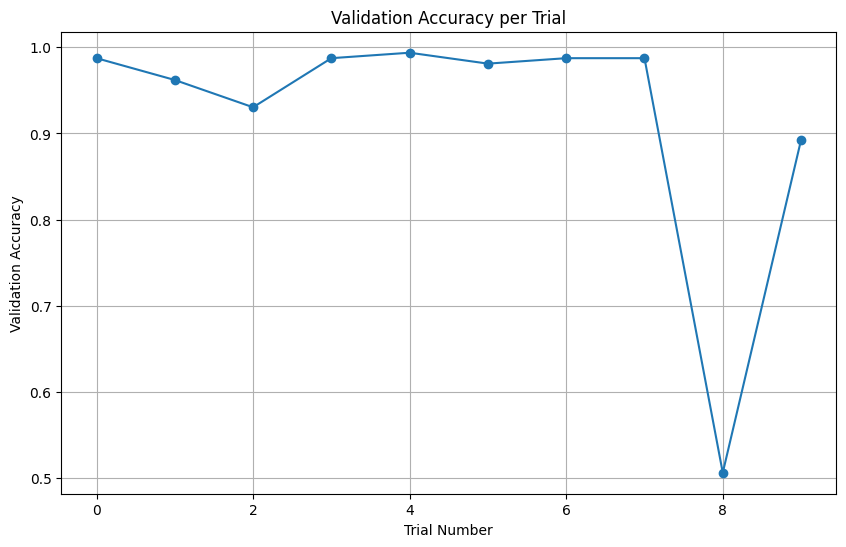

In [28]:
# plot gru model accuracy at each trial
gru_trial_df = gru_trial_df.sort_values(by='Trial #', ascending = True)
plt.figure(figsize=(10, 6))
plt.plot(gru_trial_df["Val Accuracy"].values, marker='o')
plt.title("Validation Accuracy per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

Validation accuracy peaked on the fourth trial at 0.9936, it was the worst on the 8th trial being 0.5063. Each trial having its own unique pair of hyperparameters. The best model's hyperparameter were shown above.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(158, 3)


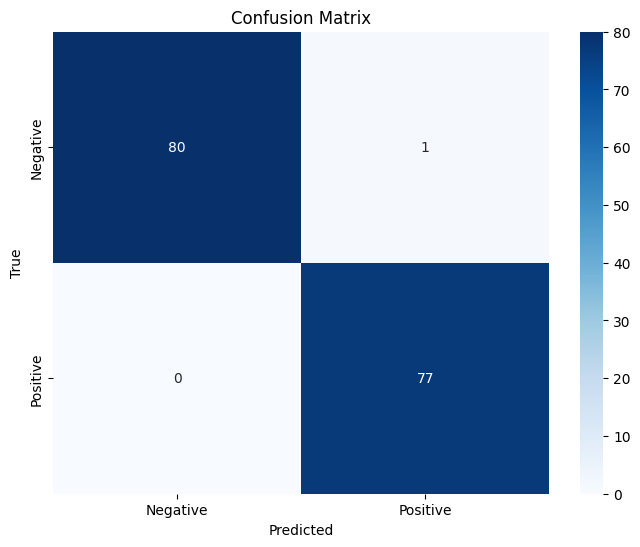

In [17]:
# create confusion matrix of best gru model predictions
best_gru_pred = (best_GRU.predict(val_seq_pad) > 0.5).astype("int32")
gru_cm = confusion_matrix(val['label'], best_gru_pred)

print(val.shape)
plt.figure(figsize=(8,6))
sns.heatmap(gru_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# other metrics

gru_precision = precision_score(val['label'], best_gru_pred)
gru_recall = recall_score(val['label'], best_gru_pred)
gru_f1 = f1_score(val['label'], best_gru_pred)

print(f"Precision: {gru_precision:.2f}")
print(f"Recall:    {gru_recall:.2f}")
print(f"F1 Score:  {gru_f1:.2f}")

Precision: 0.99
Recall:    1.00
F1 Score:  0.99


- The precision being 0.99 means that out of all emails that were predicted to be fake, 99% were truly fake.
- The recall being 1.00 means that out of all emails that were predicted to be real job opportunities, 100% were predicted to be truly real.
- A 0.99 f1 score entails both precision and recall, meaning 99% of the predictions are truly real and truly false.
- The confusion matrix shows how well the predictions were on the validation data. 80 were truly negative, 77 were truly positive, and only 1 was false postiive. Meaning that 1 scam email might have been successful.

## Comparison to other model

Building a simple conv1d model for binary classification.

In [19]:
conv1d = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Conv1D(filters= 64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(), # identifies patterns in text for conv1d
    Dropout(0.5),
    Dense(1, activation='sigmoid') # output layer should be between 0 and 1 so use sigmoid activation function
])

conv1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
conv1d.fit(train_seq_pad, train['label'], validation_data=(val_seq_pad, val['label']), epochs=10, batch_size=32, verbose=1)

conv1d_loss, conv1d_acc = conv1d.evaluate(val_seq_pad, val['label'])
print('validation accuracy for the conv1d model: ' , conv1d_acc)

Epoch 1/10


C:\Users\Kyle\Desktop\ml week 6\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6313 - loss: 0.6773 - val_accuracy: 0.9304 - val_loss: 0.6166
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9130 - loss: 0.5844 - val_accuracy: 0.9557 - val_loss: 0.4945
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9552 - loss: 0.4421 - val_accuracy: 0.9620 - val_loss: 0.3331
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - loss: 0.2755 - val_accuracy: 0.9620 - val_loss: 0.2063
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.1559 - val_accuracy: 0.9747 - val_loss: 0.1389
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.1052 - val_accuracy: 0.9810 - val_loss: 0.1036
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.0705 - val_accuracy: 0.9873 - val_loss: 0.0829
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0438 - val_accuracy: 0.9873 - val_loss: 0.0718
Epo

In [20]:
# hyperparameter tuning for simple conv1d model

def build_conv_model(hp):
    vocab_size = hp.Choice('max_vocab', [2500, 5000, 10000])  # max number of words, limits vocabulary size in tokenization
    max_length = hp.Choice('max_words', [30, 60, 80]) # max email length in tokens, pads sequences to ensure same length during training
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=hp.Choice('embedding_output_dim', [32, 64, 128]), input_length=max_length),
        Conv1D(filters= hp.Choice('conv1d units', [32, 64, 128]), kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(), # identifies patterns in text for conv1d
        Dropout(hp.Choice('dropout', [0.3, 0.5, 0.7])),
        Dense(1, activation='sigmoid') # output layer should be between 0 and 1 so use sigmoid activation function
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner1d = kt.RandomSearch(
    build_conv_model,
    objective=kt.Objective('val_accuracy', direction='max'),  # tell Keras Tuner to maximize validation accuracy score
    max_trials=10, # 10 combinations
    executions_per_trial=1, # how many times to run a hyperparameter combination
    directory='tuner_dir2', # directory to save tuner log
    project_name='emails_conv' 
)
tuner1d.search(train_seq_pad, train['label'], epochs=10, validation_data=(val_seq_pad, val['label']), verbose=1)

Reloading Tuner from tuner_dir2\emails_conv\tuner0.json


In [21]:
# table of each trial and validation accuracy score at each trial along with hyperparameters for the conv model
trial_data = []

for trial in tuner1d.oracle.trials.values():
    trial_data.append({
        'Trial #': trial.trial_id,
        **trial.hyperparameters.values,
        'Val Accuracy': trial.score
    })

conv_trial_df = pd.DataFrame(trial_data)
conv_trial_df = conv_trial_df.sort_values(by='Val Accuracy', ascending = False)
display(conv_trial_df)

,Trial #,max_vocab,max_words,embedding_output_dim,conv1d units,dropout,Val Accuracy
0,05,2500,80,128,32,0.7,0.993671
3,06,10000,60,128,128,0.3,0.993671
5,08,10000,80,64,128,0.5,0.993671
1,04,10000,60,64,32,0.5,0.987342
2,07,10000,30,64,32,0.3,0.987342
4,09,5000,30,64,128,0.3,0.987342
6,01,2500,30,32,32,0.5,0.987342
7,03,10000,30,64,128,0.7,0.987342
9,00,2500,80,64,64,0.7,0.987342
8,02,2500,60,64,128,0.3,0.974684


In [36]:
# get best conv1 model
best_conv = tuner1d.get_best_models(num_models=1)[0]
best_conv_hypparam = tuner1d.get_best_hyperparameters(num_trials=1)[0]
print(best_conv_hypparam.values)

{'max_vocab': 2500, 'max_words': 80, 'embedding_output_dim': 128, 'conv1d units': 32, 'dropout': 0.7}


### Accuracy on test data

In [37]:
# validation accuracy on best gru model
val_loss, val_acc = best_GRU.evaluate(val_seq_pad, val['label'])
print('validation accuracy for best GRU model: ' , val_acc)

# test accuracy on best gru model
test_loss, test_acc = best_GRU.evaluate(test_seq_pad, test['label'])
print('test accuracy for best GRU model: ' , test_acc)

# val acc on best conv1d model
val_loss, val_acc = best_conv.evaluate(val_seq_pad, val['label'])
print('validation accuracy for best conv1d model: ' , val_acc)

# test accuracy on best conv1d model
test_loss, test_acc = best_conv.evaluate(test_seq_pad, test['label'])
print('test accuracy for best conv1d model: ' , test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.1843 
validation accuracy for best GRU model:  0.9936708807945251
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9848 - loss: 0.2115 
test accuracy for best GRU model:  0.9797979593276978
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.1443  
validation accuracy for best conv1d model:  0.9936708807945251
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.1657 
test accuracy for best conv1d model:  0.9797979593276978


In summary the validation accuracy for the base GRU model was around 0.9936 and 0.9873 for the base Conv1D model. After hyperparameter tuning, the best validation accuracy for the GRU model remained around 0.9936 and slightly improved for the Conv1D model to 0.9936. The test accuracy also stayed consistent for both models after tuning, with the GRU model reaching 0.9798 and the Conv1D model also achieving 0.9798. Although performance ended up being quite similar for both models after hyperparameter tuning, the best hyperparameters values were somwhat different. This sort of makes sense since with conv1d identifying short patterns like typos or certain words with urgency might make it easier to classify the emails well. And with GRU the context is learned, things like urgency or asking for money might make it just as good at classifying the emails.

Troubleshooting: At first when I was training the gru model, my accuracy was only around 0.50. I wondered if there was something wrong with my data, with the length being somewhat varied. I tried changing some hyperparameters and realized that the max_length value had been too high. At first it was at 120 and I realized that there were too many 0s in the training tokenized data and it was underfitting so reduced that and accuracy improved. I then learned to tune it further while hyperparameter tuning. 

A hyperparameter that worked well in tuning has to be the max_words. The best gru model had 30 as the value for max_words whereas previously it was 60. The performance did not improve much if at all but previously I mentioned in the troubleshooting, when it was 120 the accuracy was a lot lower. The other hyperparameters were basically the same as the base model. Perhaps a larger dataset would have been more ideal for evaluating this performance. For the best conv1d model both the max_vocab and max_words changed, max_vocab decreased to 2500 and max_words increased to 80. This makes sense, it performed better when it had smaller vocab to track and bigger email lengths to evaluate. This model specializes in recognizing short patterns and it needed more total length to identify it.

Hyperparameter tuning plan is listed above.

## Conclusion

To conclude: The base GRU model performed better than the base conv1D model but they were both already very good. After hyperparameter tuning, their performance ended up being quite similar, both being very good with the accuracy at around 0.99. Essentially these models will accurately classify emails as scams 99% of the time.

My hypothesis that the difference in email lengths impacted the training, as described in my troubleshooting portion of the result section. Changing the hyperparameter of max length to be smaller allows less noise and underfitting to occur while training.

What I learned was that deep learning neural networks are flexible and more layers can be added to optimize performance. For example I added a batch normalization layer to normalize the data after the computation to help troubleshoot why my models were performing so badly.

A suggestion I would try in the future is adding more longer emails into the dataset. I feel like the length of most emails sort of skewed to being shorter in length and it is not very realistic as most job opportunity emails are usually longer. I would also like to try different natural language processing models as well for comparison. 

https://github.com/kyleung1/ml-week-6